In [ ]:

import kagglehub
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')

print('Data source import complete.')


Data source import complete.


# Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torchaudio
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor,Trainer,TrainingArguments, Wav2Vec2ForSequenceClassification

# Load the Dataset

In [ ]:
import os

print(os.listdir(ejlok1_toronto_emotional_speech_set_tess_path))

['TESS Toronto emotional speech set data', 'tess toronto emotional speech set data']


In [ ]:
import os

paths = []
labels = []

# Root dataset path from kagglehub
root_path = ejlok1_toronto_emotional_speech_set_tess_path

# Use only this subdirectory
data_dir = os.path.join(root_path, 'TESS Toronto emotional speech set data')

# Walk through the directory to collect file paths and labels
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith('.wav'):
            full_path = os.path.join(dirname, filename)
            paths.append(full_path)

            # Extract the emotion label from filename
            label = filename.split('_')[-1].split('.')[0]
            labels.append(label.lower())

print(f"Loaded {len(paths)} audio files from 'TESS Toronto emotional speech set data'")
print(f"Example path: {paths[0]}")
print(f"Example label: {labels[0]}")


Loaded 2800 audio files from 'TESS Toronto emotional speech set data'
Example path: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
Example label: fear


In [ ]:
len(paths)

2800

In [ ]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [ ]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [ ]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [ ]:
df['label'].value_counts()

,count
label,
fear,400
angry,400
disgust,400
neutral,400
sad,400
ps,400
happy,400


# Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

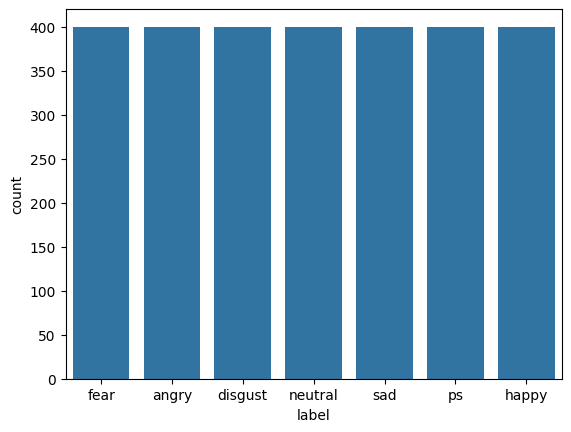

In [ ]:
sns.countplot(data=df, x='label')

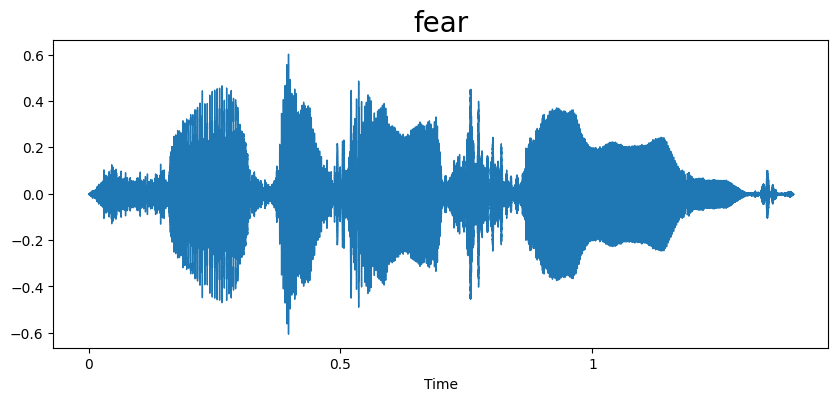

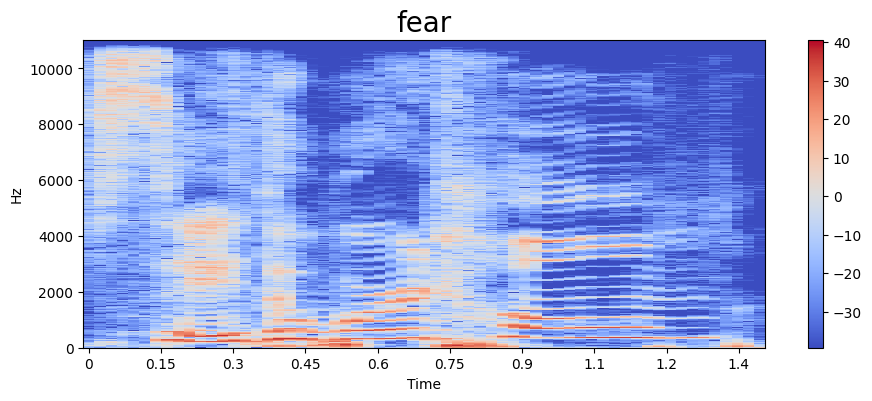

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

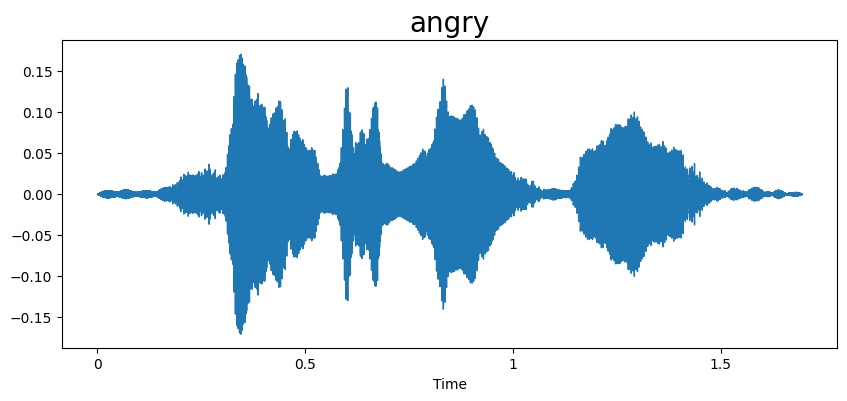

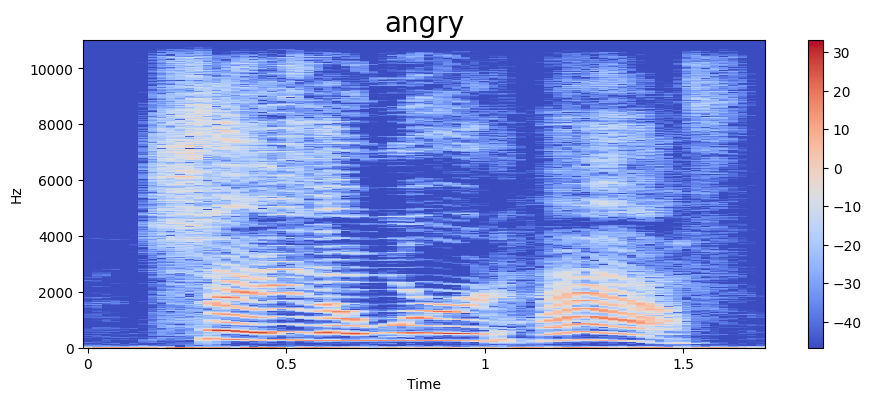

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

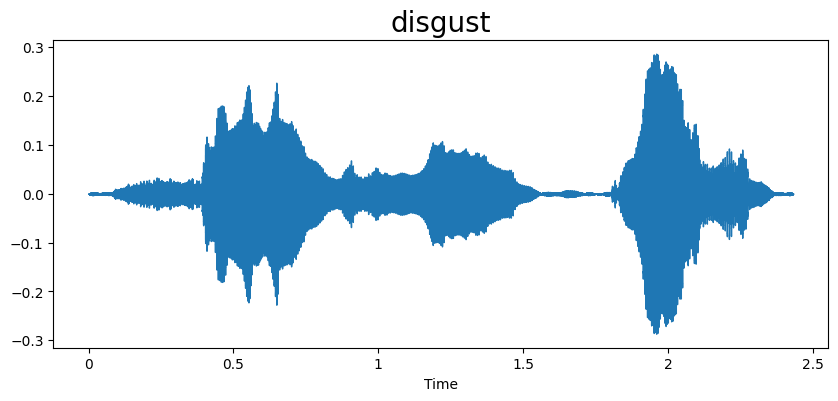

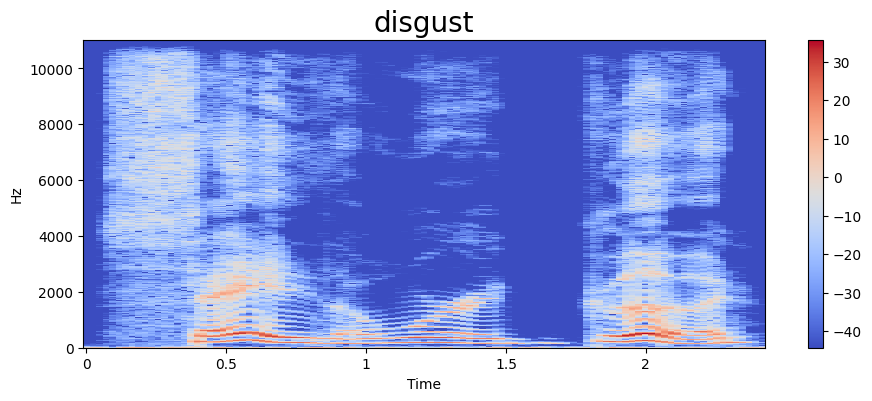

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

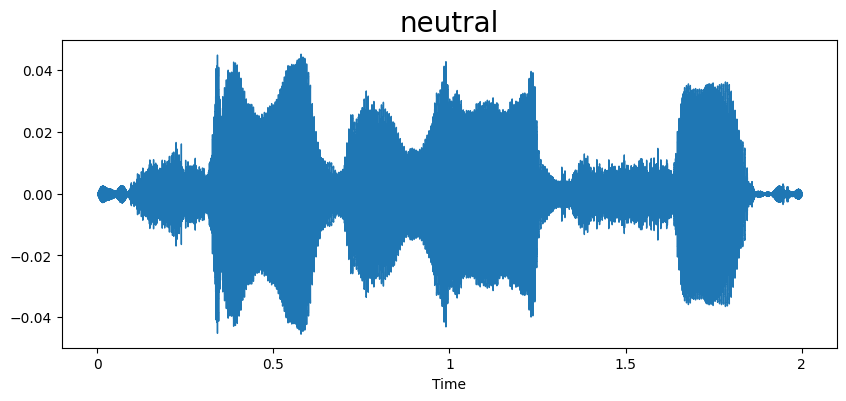

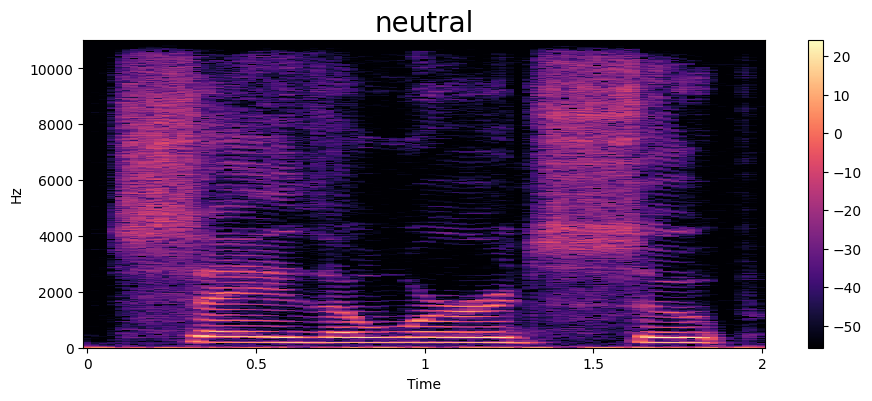

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

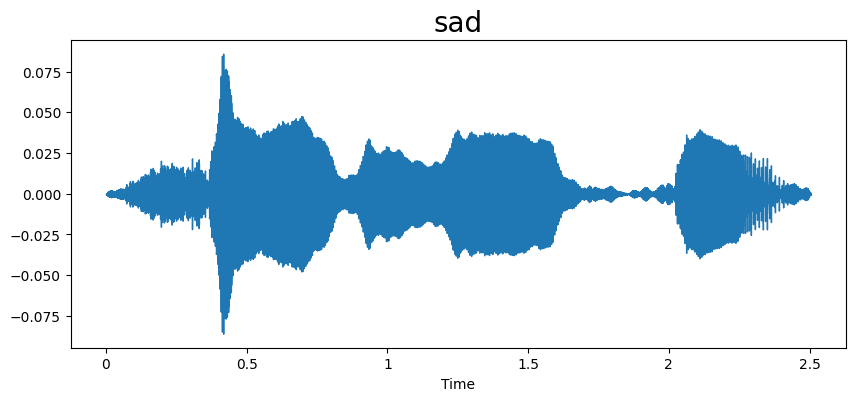

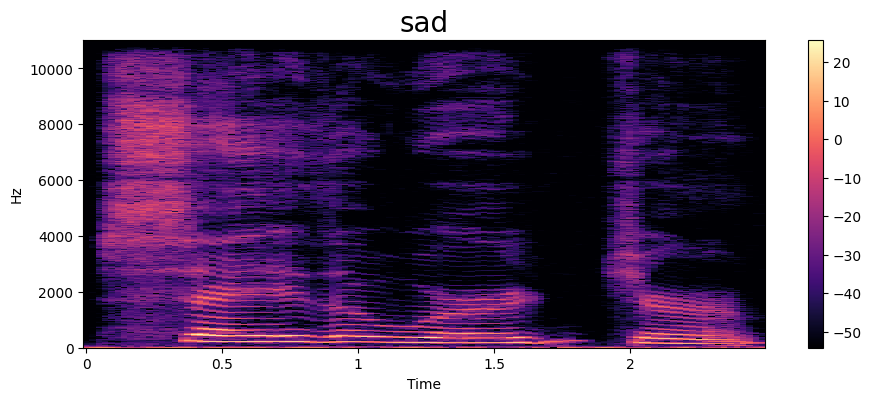

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

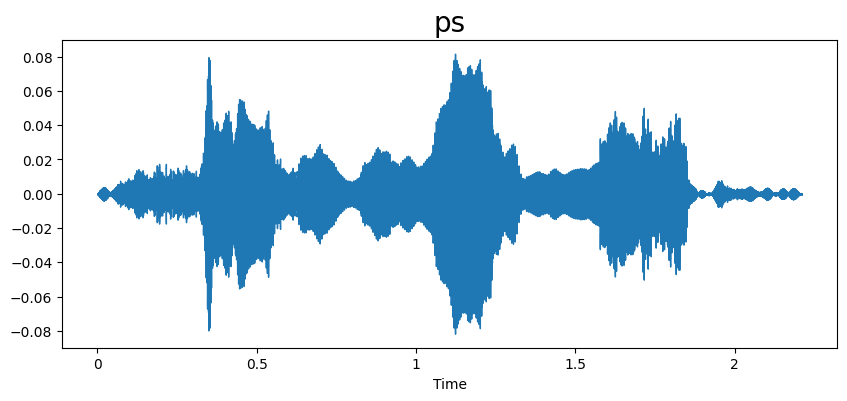

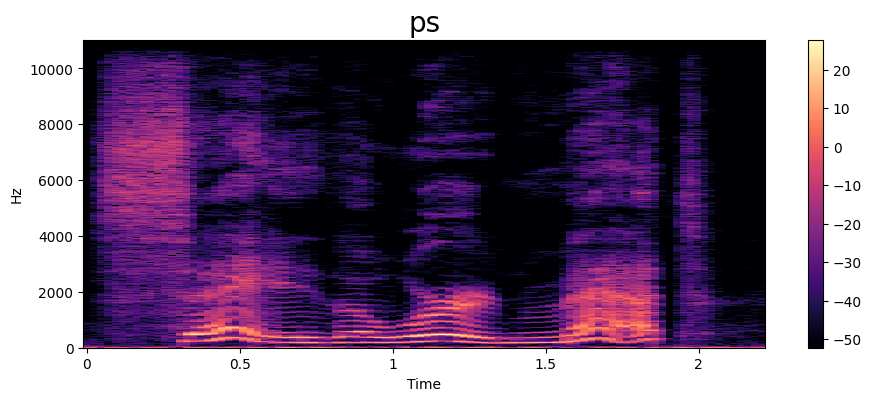

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

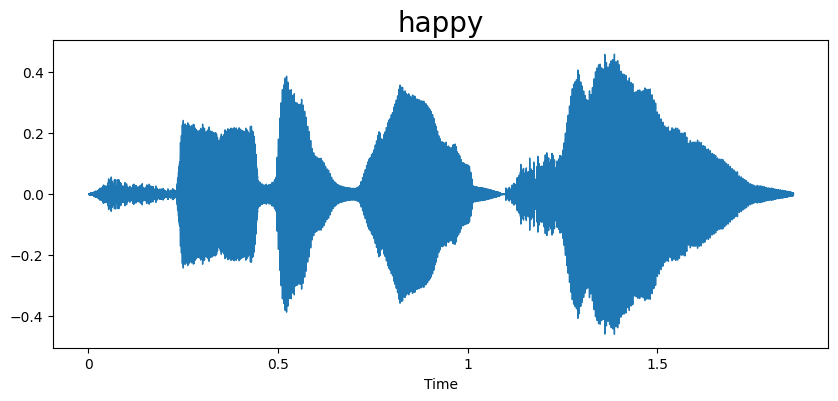

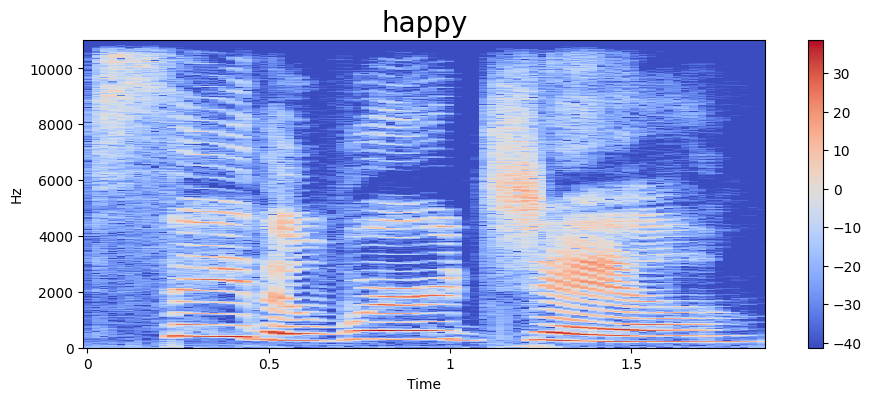

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Create custom dataset class

In [ ]:
df.head(2)

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [ ]:
label_map={label: idx for idx,label in enumerate(df['label'].unique())}
inverse_label_map={idx: label for label,idx in label_map.items()}
df['label']=df['label'].map(label_map)
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,0
1,/kaggle/input/toronto-emotional-speech-set-tes...,0
2,/kaggle/input/toronto-emotional-speech-set-tes...,0
3,/kaggle/input/toronto-emotional-speech-set-tes...,0
4,/kaggle/input/toronto-emotional-speech-set-tes...,0


In [ ]:
class SpeechEmotionDataset(Dataset):
    def __init__(self,df,processor,max_length=32000):
        self.df=df
        self.processor=processor
        self.max_length=max_length
    def __len__(self):
        return len(self.df)
    # Corrected typo from __getitam__ to __getitem__
    def __getitem__(self,idx):
        audio_path=self.df.iloc[idx]['speech']
        label=self.df.iloc[idx]['label']
        speech,sr=librosa.load(audio_path,sr=16000)

        if len(speech)>self.max_length:
            speech=speech[:self.max_length]
        else:
            speech=np.pad(speech,(0,self.max_length-len(speech)),'constant')
        # Corrected typo in sampling_rate
        inputs=self.processor(speech,sampling_rate=16000,return_tensors='pt',padding=True,truncate=True,max_length=self.max_length)
        input_values=inputs.input_values.squeeze()
        return {'input_values':input_values,'labels':torch.tensor(label,dtype=torch.long)}

In [ ]:
from sklearn.model_selection import train_test_split

train_df,test_df=train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
processor=Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model=Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base',num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset=SpeechEmotionDataset(train_df,processor)
test_dataset=SpeechEmotionDataset(test_df,processor)

In [ ]:
train_dataset[0]['input_values'].size()

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


torch.Size([32000])

In [ ]:
train_dataloader=DataLoader(train_dataset,batch_size=8,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=8,shuffle=False)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

Number of training batches: 280
Number of testing batches: 70


# Set traininh arguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',                  # Output directory
    num_train_epochs=3,                      # Total number of training epochs
    per_device_train_batch_size=16,           # Batch size per device during training
    per_device_eval_batch_size=16,            # Batch size per device during evaluation
    warmup_steps=500,                        # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                       # Strength of weight decay
    logging_dir='./logs',                    # Directory for storing logs
    logging_steps=10,
    eval_strategy='steps',             # Evaluate every `eval_steps` - Changed from evaluation_strategy
    eval_steps=10,                           # Evaluation and logging steps
    save_steps=10,                           # Save checkpoint every `save_steps`
    learning_rate=2e-5,                      # Initial learning rate
    gradient_accumulation_steps=2,           # Accumulate gradients over this many steps
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_matrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,                  # The training arguments, defined above
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset,           # Evaluation dataset
    compute_metrics=compute_matrics,     # The function to compute metrics for evaluation
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: b190305031 (b190305031-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,1.947300,1.943554,0.189286,0.098747,0.191120,0.189286
20,1.945400,1.942758,0.192857,0.104385,0.200439,0.192857
30,1.943200,1.941469,0.207143,0.121999,0.240185,0.207143
40,1.943400,1.939487,0.228571,0.151050,0.242804,0.228571
50,1.939800,1.936721,0.248214,0.175683,0.379825,0.248214
60,1.936400,1.932889,0.310714,0.228796,0.248169,0.310714
70,1.931400,1.927678,0.353571,0.249716,0.270865,0.353571
80,1.926600,1.920462,0.364286,0.255758,0.256978,0.364286
90,1.920000,1.910963,0.283929,0.175809,0.273216,0.283929
100,1.906300,1.897438,0.307143,0.226965,0.471999,0.307143


TrainOutput(global_step=210, training_loss=1.7750824655805315, metrics={'train_runtime': 852.5774, 'train_samples_per_second': 7.882, 'train_steps_per_second': 0.246, 'total_flos': 1.2201848064e+17, 'train_loss': 1.7750824655805315, 'epoch': 3.0})

In [ ]:
results=trainer.evaluate()
print(results)

{'eval_loss': 1.0613656044006348, 'eval_accuracy': 0.9214285714285714, 'eval_f1': 0.9170264215477809, 'eval_precision': 0.9506677553027111, 'eval_recall': 0.9214285714285714, 'eval_runtime': 6.5656, 'eval_samples_per_second': 85.293, 'eval_steps_per_second': 5.331, 'epoch': 3.0}


In [ ]:
import numpy as np
print("Evaluation Results:")
print(f"  Accuracy: {results['eval_accuracy']:.4f}")
print(f"  F1 Score: {results['eval_f1']:.4f}")
print(f"  Precision: {results['eval_precision']:.4f}")
print(f"  Recall: {results['eval_recall']:.4f}")

Evaluation Results:
  Accuracy: 0.9214
  F1 Score: 0.9170
  Precision: 0.9507
  Recall: 0.9214


In [ ]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

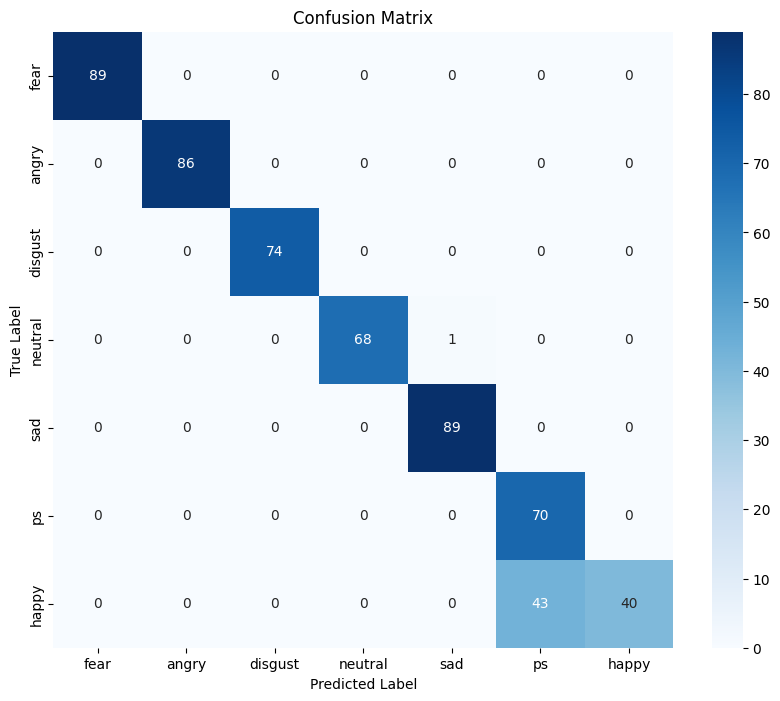

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=inverse_label_map.values(), yticklabels=inverse_label_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("\nMisclassified Examples (first 10):")
misclassified_indices = np.where(preds != labels)[0]
for i in range(min(10, len(misclassified_indices))):
    idx = misclassified_indices[i]
    true_label = inverse_label_map[labels[idx]]
    predicted_label = inverse_label_map[preds[idx]]
    audio_path = test_df.iloc[idx]['speech']
    print(f"  Audio: {os.path.basename(audio_path)}, True: {true_label}, Predicted: {predicted_label}")



Misclassified Examples (first 10):
  Audio: OAF_rough_happy.wav, True: happy, Predicted: ps
  Audio: OAF_kick_happy.wav, True: happy, Predicted: ps
  Audio: OAF_tell_happy.wav, True: happy, Predicted: ps
  Audio: OAF_mouse_happy.wav, True: happy, Predicted: ps
  Audio: OAF_gap_happy.wav, True: happy, Predicted: ps
  Audio: OAF_shout_happy.wav, True: happy, Predicted: ps
  Audio: OAF_match_happy.wav, True: happy, Predicted: ps
  Audio: OAF_near_happy.wav, True: happy, Predicted: ps
  Audio: OAF_bone_happy.wav, True: happy, Predicted: ps
  Audio: OAF_note_happy.wav, True: happy, Predicted: ps


# Test prediction

In [ ]:
import random
import torch

idx=random.randrange(0,len(test_dataset))
print("Original Label: ",int(test_dataset[idx]['labels']))
input_values=test_dataset[idx]['input_values'].unsqueeze(0)

# Check if a GPU is available and move the model and input to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_values = input_values.to(device)


with torch.no_grad():
  outputs=model(input_values)

logits=outputs.logits
predicted_label=logits.argmax(-1).item()
print("Predicted Label: ",predicted_label)

Original Label:  0
Predicted Label:  0


In [ ]:
idx=random.randrange(0,len(test_dataset))
print("Original Label: ",int(test_dataset[idx]['labels']))
input_values=test_dataset[idx]['input_values'].unsqueeze(0)

# Check if a GPU is available and move the model and input to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_values = input_values.to(device)


with torch.no_grad():
  outputs=model(input_values)

logits=outputs.logits
predicted_label=logits.argmax(-1).item()
print("Predicted Label: ",predicted_label)

Original Label:  2
Predicted Label:  2
